In [ ]:
# !python -m spacy download ru_core_news_lg

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm
from sklearn.model_selection import GroupKFold

import pytorch_lightning as pl

import utils

%load_ext autoreload
%autoreload 1
%aimport utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
data_folder = '../data/'

In [7]:
df = utils.read_preprocessed_financial_data(data_folder, enc_cols=['mcc_description', 'tr_description'])
df.shape 

(3751083, 10)

In [8]:
df.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,mcc_description,tr_description,week
0,39026145.0,0,4814.0,1030,-2245.92,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",0
1,39026145.0,13328582400,4814.0,1030,-5614.79,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",0
2,39026145.0,17673984000,4814.0,1030,-1122.96,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",1
3,39026145.0,30168547200,4814.0,1030,-2245.92,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",1
4,39026145.0,48592051200,4814.0,1030,-2245.92,311690,1.0,"[-0.102810316, -0.12563597, -0.11075681, -0.06...","[0.07799721, 0.21862344, 0.1882922, -0.1851609...",1


In [9]:
clients = df['customer_id'].unique()
clients = clients[:100] # drop this row (I just tested the code with small amount of data)

df_week = []

for client_id in tqdm(clients):
    client_data = df[df['customer_id'] == client_id]
    client_weeks = client_data.week.unique()
    
    for week in client_weeks:
        client_data_week = client_data[client_data['week'] == week]
        df_week.append(
            {
                'transactions': client_data_week['mcc_code'].tolist(),
                'amounts': client_data_week['amount'].tolist(),
                'tr_datetime': client_data_week['tr_datetime'].tolist(),
                'tr_type': client_data_week['tr_type'].tolist(),
                'mcc_description': client_data_week['mcc_description'].tolist(), # add mcc_description embeddings
                'tr_description': client_data_week['tr_description'].tolist(), # add tr_description embeddings
                'term_id': client_data_week['term_id'].tolist(),
                'customer_id': client_id, 
                'week': week,
                'gender': client_data_week['gender'].tolist()
            }
        )

100%|██████████| 100/100 [00:08<00:00, 12.08it/s]


In [10]:
df_week = pd.DataFrame(df_week)
df_week.shape

(5990, 10)

In [11]:
df_week.head(3)

,transactions,amounts,tr_datetime,tr_type,mcc_description,tr_description,term_id,customer_id,week,gender
0,"[4814.0, 4814.0, 5499.0, 5499.0, 5499.0, 5499....","[-2245.92, -5614.79, -1392.47, -920.83, -1010....","[0, 13328582400, 3317241600, 9680601600, 14449...","[1030, 1030, 1010, 1010, 1010, 1010, 1010, 101...","[[-0.102810316, -0.12563597, -0.11075681, -0.0...","[[0.07799721, 0.21862344, 0.1882922, -0.185160...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,"[4814.0, 4814.0, 4814.0, 4814.0, 4814.0, 5499....","[-1122.96, -2245.92, -2245.92, -2245.92, -2245...","[17673984000, 30168547200, 48592051200, 487840...","[1030, 1030, 1030, 1030, 1030, 1010, 1010, 101...","[[-0.102810316, -0.12563597, -0.11075681, -0.0...","[[0.07799721, 0.21862344, 0.1882922, -0.185160...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,"[4814.0, 4814.0, 4814.0, 5331.0, 5331.0, 5331....","[-2245.92, -449.18, -1122.96, -6288.56, -1122....","[42837984000, 79248240000, 79340169600, 0, 0, ...","[1030, 1030, 1030, 1110, 1110, 1110, 1110, 101...","[[-0.102810316, -0.12563597, -0.11075681, -0.0...","[[0.07799721, 0.21862344, 0.1882922, -0.185160...","[311690, 311690, 311690, 311690, 311690, 31169...",39026145.0,2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [12]:
MIN_LEN = 20
MAX_LEN = 50

lens = df_week.transactions.apply(lambda x: len(x))
df_week = df_week[(lens >= MIN_LEN) & (lens <= MAX_LEN)]
df_week.shape

(598, 10)

In [13]:
features = ['transactions', 'amounts', 'tr_datetime', 'tr_type', 'term_id', 'mcc_description', 'tr_description'] 
desc_cols = ['mcc_description', 'tr_description']

INPUT_SIZE = len(list(set(features) - set(desc_cols)))
if 'mcc_description' in features:
    INPUT_SIZE += len(df['mcc_description'].iloc[0])
if 'tr_description' in features:
    INPUT_SIZE += len(df['tr_description'].iloc[0])
    
EPOCHS = 10
N_SPLITS = 5

In [14]:
INPUT_SIZE

605

# GRU

In [15]:
base_model = utils.RNN(
    input_size=INPUT_SIZE,
    output_size=1,
    hidden_rnn_size=16,
    base_type="GRU"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 29.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

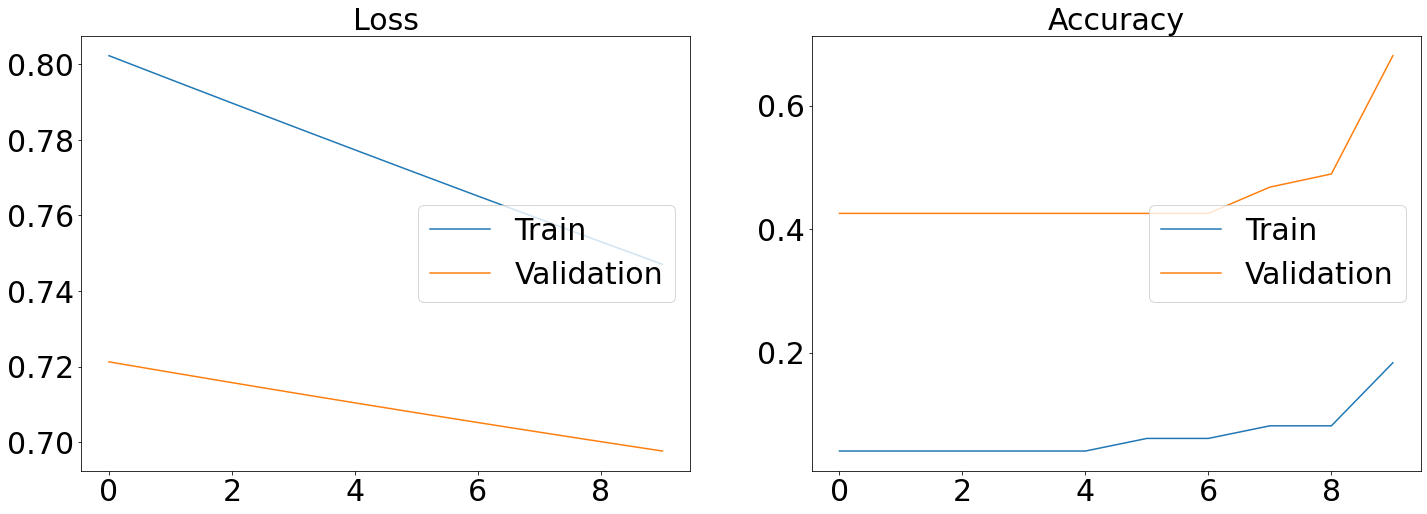

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 29.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

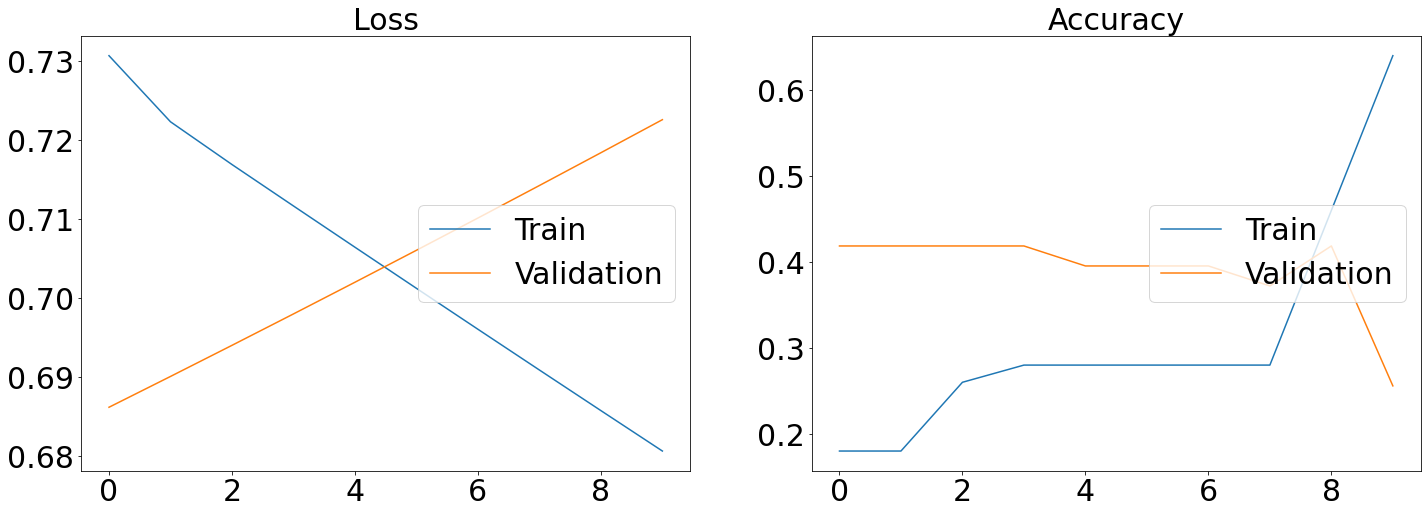

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 29.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

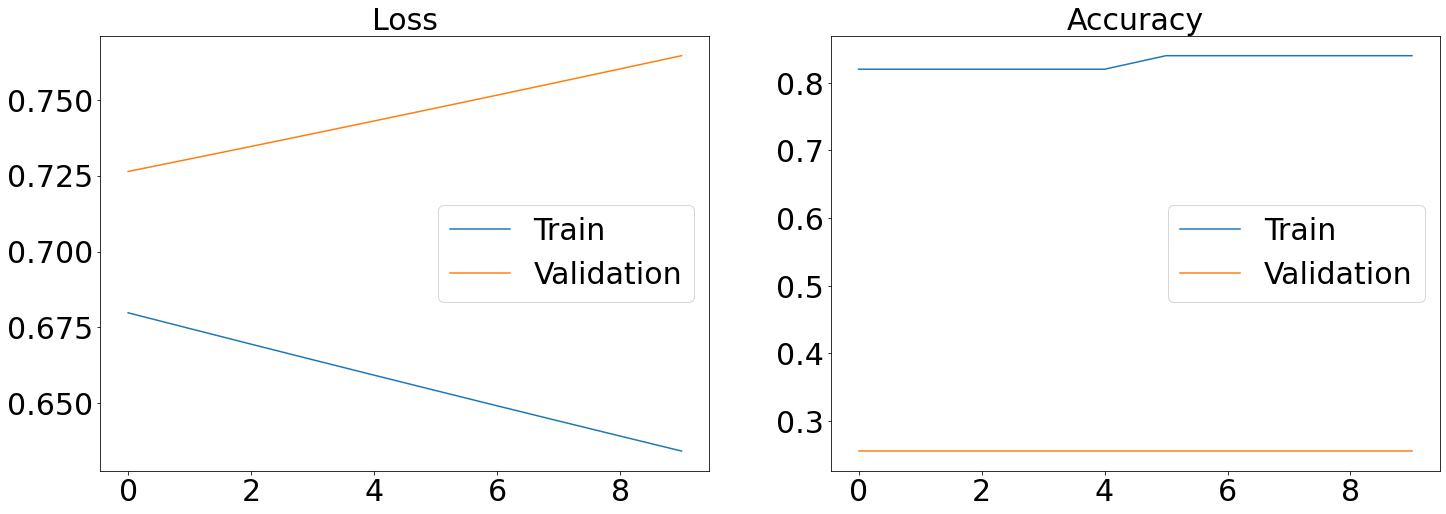

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 29.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

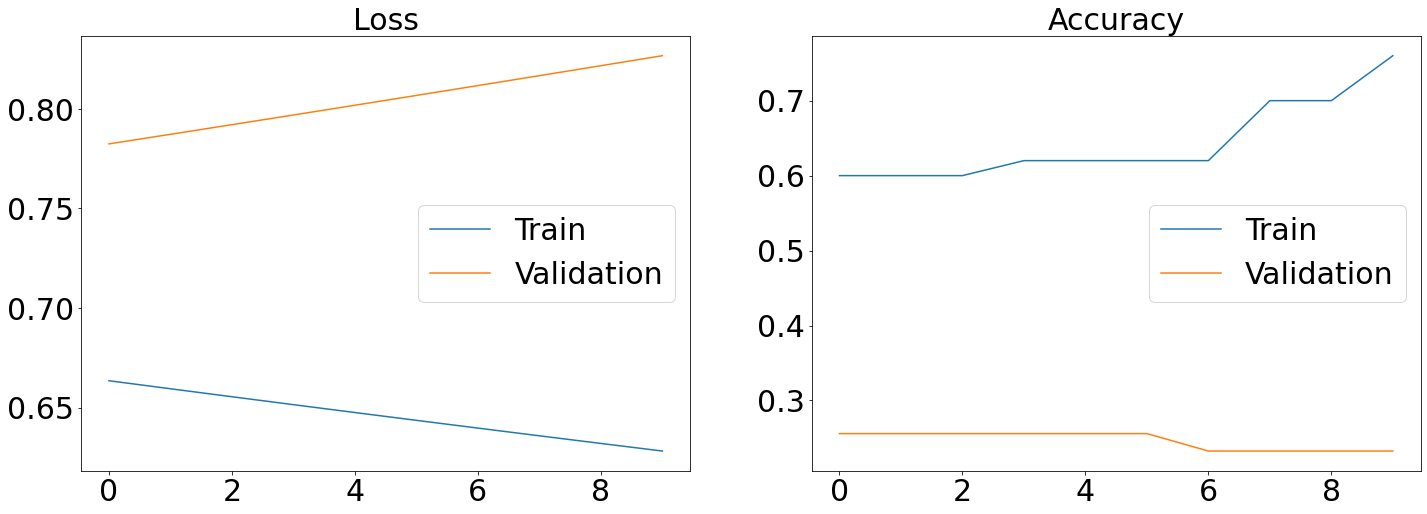

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 29.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

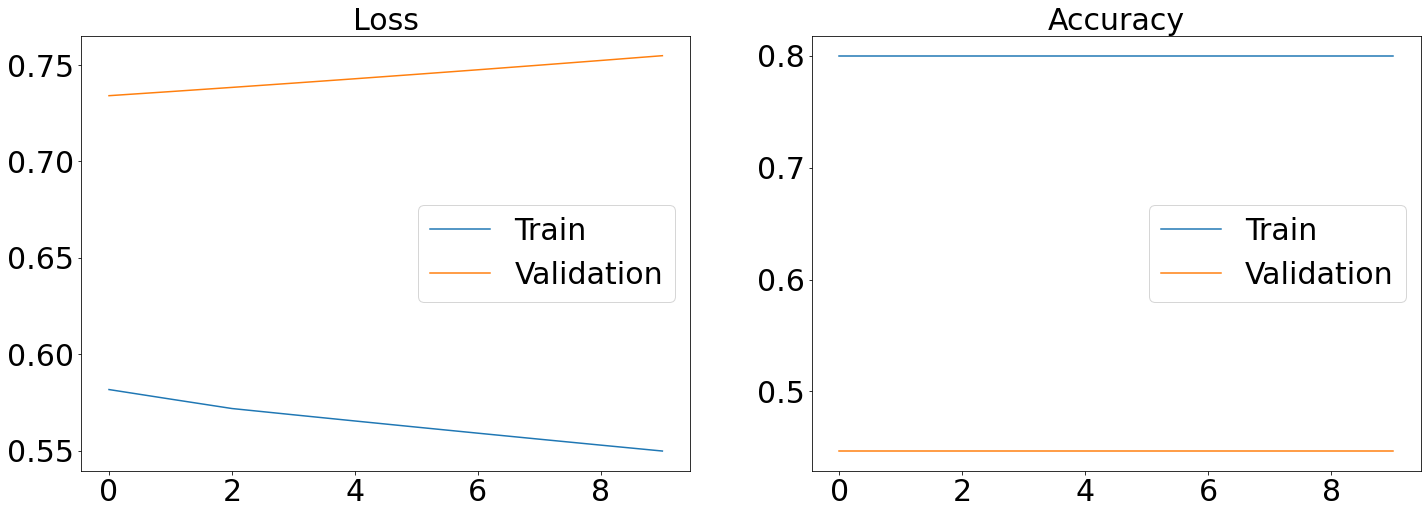

{'Accuracy': [0.38,
  1.0,
  0.8723404255319149,
  0.7380952380952381,
  0.21739130434782608],
 'ROC AUC': [0.3168859649122807,
  1.0,
  0.6178861788617886,
  0.6319648093841641,
  0.3822843822843822],
 'PR AUC': [0.24220430107526877,
  1.0000000000000002,
  0.9422158928403495,
  0.8438265429252363,
  0.32738667856543435]}

In [16]:
metrics_gru = utils.cross_validation(df_week, "GRU", base_model, features, n_splits=N_SPLITS, epochs=EPOCHS, gpus=[0])
metrics_gru

In [17]:
for metric_name, metric_val in metrics_gru.items():
    print('{}: {} ± {}'.format(metric_name, np.array(metric_val).mean(), np.array(metric_val).std()))

Accuracy: 0.6415653935949959 ± 0.2964424417753329
ROC AUC: 0.5898042670885232 ± 0.24015642679144542
PR AUC: 0.6711266830812578 ± 0.320500814448046


In [18]:
base_model = utils.RNN(
    input_size=INPUT_SIZE,
    output_size=1,
    hidden_rnn_size=16,
    base_type="GRU"
)

# LSTM

In [19]:
base_model = utils.RNN(
    input_size=INPUT_SIZE,
    output_size=1,
    hidden_rnn_size=16,
    base_type="LSTM"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 39.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
39.9 K    Trainable params
0         Non-trainable params
39.9 K    Total params
0.160     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

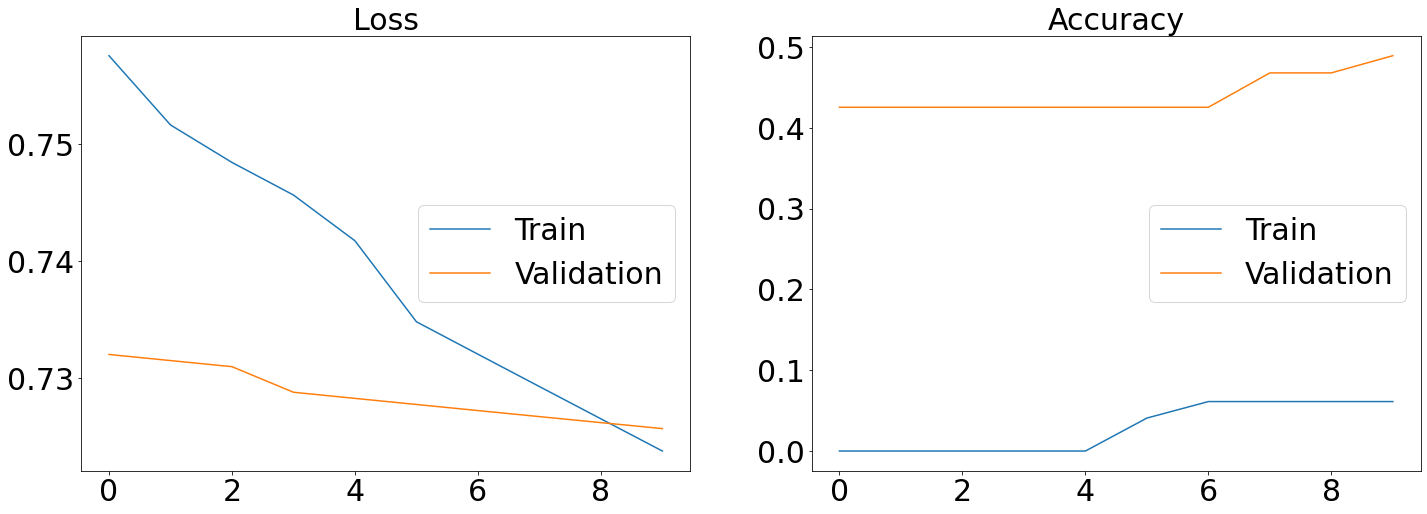

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 39.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
39.9 K    Trainable params
0         Non-trainable params
39.9 K    Total params
0.160     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

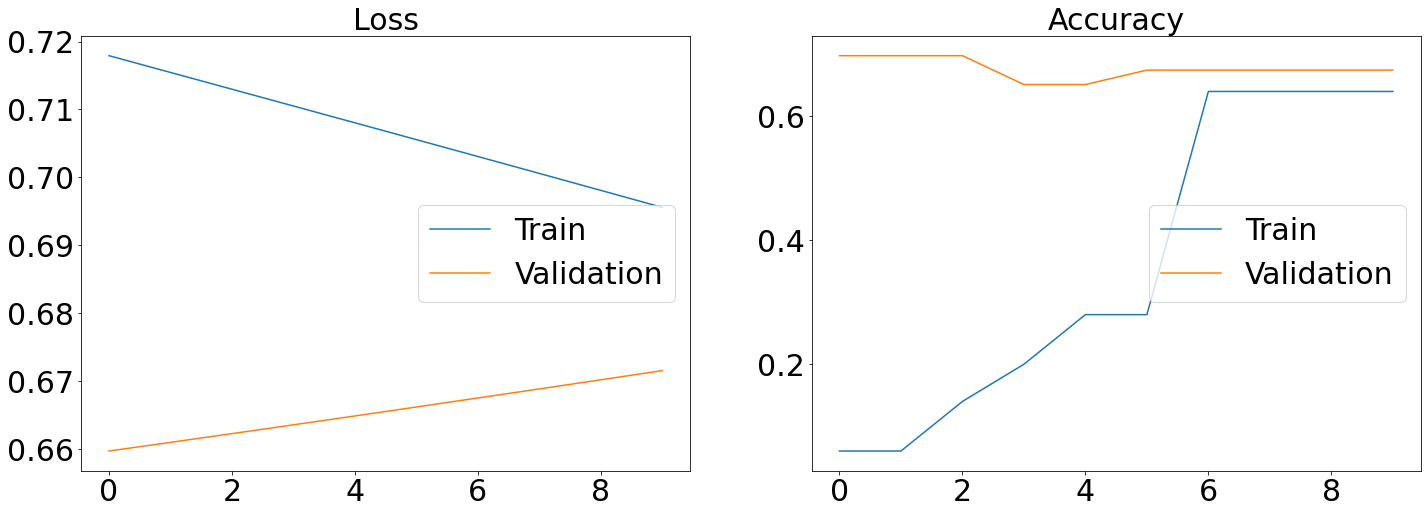

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 39.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
39.9 K    Trainable params
0         Non-trainable params
39.9 K    Total params
0.160     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

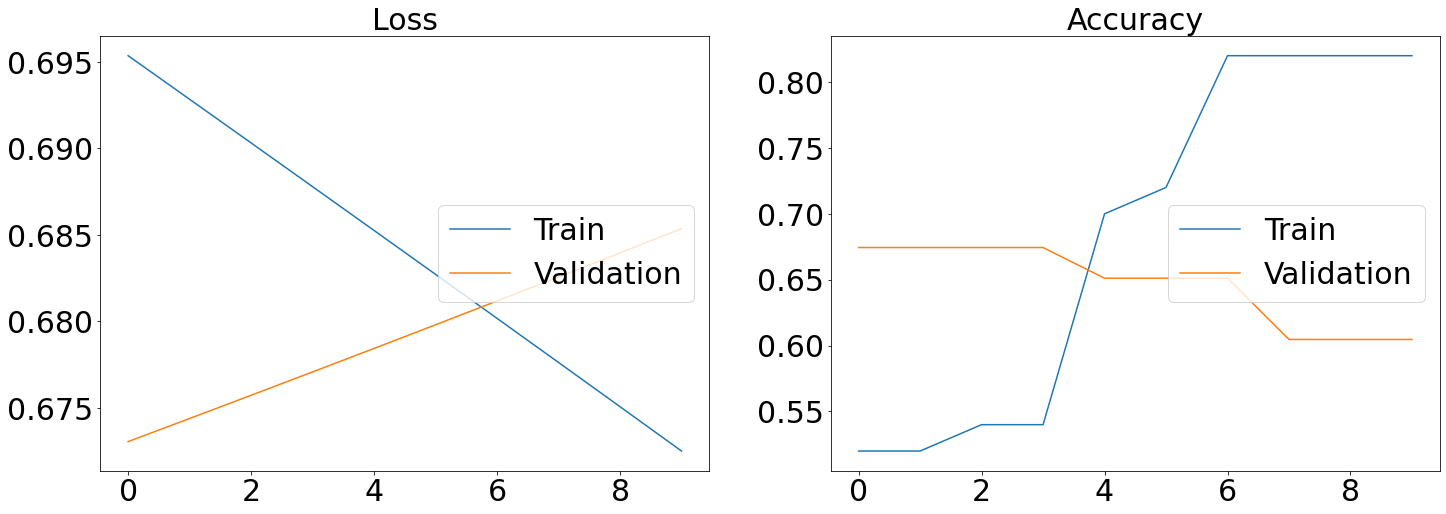

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 39.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
39.9 K    Trainable params
0         Non-trainable params
39.9 K    Total params
0.160     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

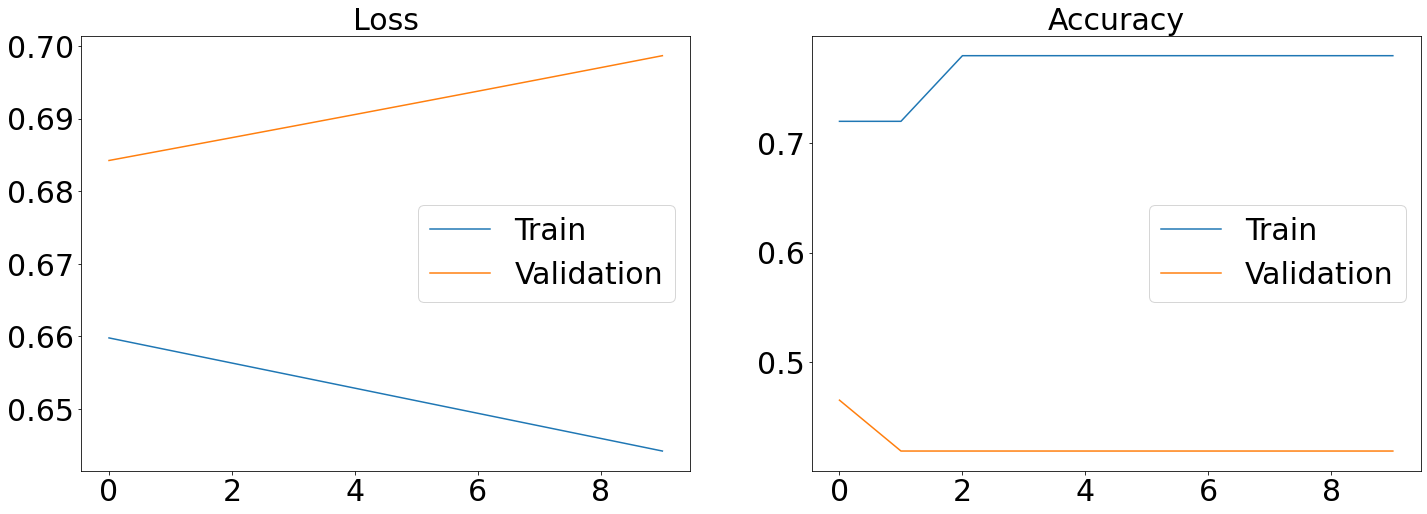

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 39.9 K
1 | loss_function | BCELoss | 0     
------------------------------------------
39.9 K    Trainable params
0         Non-trainable params
39.9 K    Total params
0.160     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

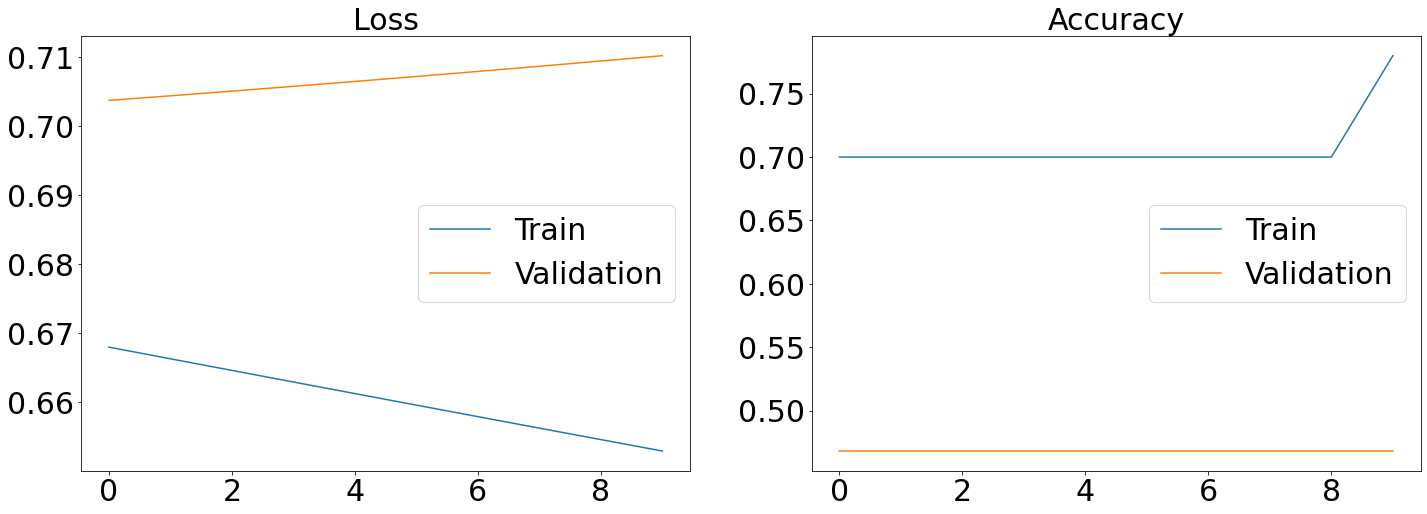

{'Accuracy': [0.74,
  0.7346938775510204,
  0.48936170212765956,
  0.7142857142857143,
  0.2608695652173913],
 'ROC AUC': [0.6973684210526315,
  0.7346938775510204,
  0.22764227642276424,
  0.23460410557184752,
  0.46386946386946387],
 'PR AUC': [0.46153846153846156,
  1.0,
  0.8527340813243806,
  0.6352358998427226,
  0.5360046542114838]}

In [20]:
metrics_lstm = utils.cross_validation(df_week, "LSTM", base_model, features, n_splits=N_SPLITS, epochs=EPOCHS, gpus=[0])
metrics_lstm

In [21]:
for metric_name, metric_val in metrics_lstm.items():
    print('{}: {} ± {}'.format(metric_name, np.array(metric_val).mean(), np.array(metric_val).std()))

Accuracy: 0.5878421718363571 ± 0.18831616285554026
ROC AUC: 0.47163562889354554 ± 0.21722428412127034
PR AUC: 0.6971026193834097 ± 0.20061829077167223


# RNN

In [22]:
base_model = utils.RNN(
    input_size=INPUT_SIZE,
    output_size=1,
    hidden_rnn_size=16,
    base_type="RNN"
)

In [ ]:
metrics_rnn = utils.cross_validation(df_week, "RNN", base_model, features, n_splits=N_SPLITS, epochs=EPOCHS, gpus=[0])
metrics_rnn

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type    | Params
------------------------------------------
0 | model         | RNN     | 10.0 K
1 | loss_function | BCELoss | 0     
------------------------------------------
10.0 K    Trainable params
0         Non-trainable params
10.0 K    Total params
0.040     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
for metric_name, metric_val in metrics_rnn.items():
    print('{}: {} ± {}'.format(metric_name, np.array(metric_val).mean(), np.array(metric_val).std()))